In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e22/sample_submission.csv
/kaggle/input/playground-series-s3e22/train.csv
/kaggle/input/playground-series-s3e22/test.csv


# **馬の健康への影響を予測する**
[Predict Health Outcomes of Horses](https://www.kaggle.com/competitions/playground-series-s3e22/overview)

# 参考資料
**書籍**


**Kaggle**
- [PS3E22 | Multi-Class Classification for Beginners](https://www.kaggle.com/code/iqbalsyahakbar/ps3e22-multi-class-classification-for-beginners)
- [🐎 Horse Health: A beginner friendly guide 🩺](https://www.kaggle.com/code/kacperrabczewski/horse-health-a-beginner-friendly-guide)


**自分で作成したファイル**
- Home_Credit_Default_Risk
- 肝硬変の転帰の多クラス予測

**その他**


- processor.pyの実行
- モデルの構築
- バリデーション・ハイパーパラメータ
- 予測・提出

In [2]:
# 処理
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from lightgbm import LGBMClassifier # 特徴量の重要度評価で用いる

import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

FILE_PATH = '/kaggle/input/playground-series-s3e22/'
OUTPUT_DIR = '/kaggle/working/'

train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

train_id = train['id']

test_id = test['id']

target = train['outcome']
target_col = 'outcome'

target_name = str(train.iloc[:, [18]].columns.tolist()) # カラム数-2の値が目的変数

df = pd.concat([train, test], axis=0)
df.reset_index(inplace=True)

# 説明変数をデータ型ごとに代入する
numerical_features = df._get_numeric_data().columns
categorical_features = df.drop(numerical_features, axis=1).columns

numerical_features = numerical_features.drop('id')

def missing_values(df):

    return df

def outlier(df):
    df['lesion_2'] = df['lesion_2'].apply(lambda x: 1 if x>0 else 0)

    return df

def scaling(df):
    df_scale = df[numerical_features]
    sc = MinMaxScaler()
    df[numerical_features] = pd.DataFrame(sc.fit_transform(df_scale), columns = df_scale.columns)

    return df

def create_new_features(df):
    df["pain"] = df["pain"].replace('slight', 'moderate')
    df["peristalsis"] = df["peristalsis"].replace('distend_small', 'normal')
    df["rectal_exam_feces"] = df["rectal_exam_feces"].replace('serosanguious', 'absent')
    df["nasogastric_reflux"] = df["nasogastric_reflux"].replace('slight', 'none')
    
    df["abs_rectal_temp"] = (df["rectal_temp"] - 37.8).abs()

    return df

def one_hot_encoding(df, cat_cols):
    df = pd.get_dummies(df, columns=cat_cols)
    df[target_col] = df[target_col].map({'died':0,'euthanized':1,'lived':2})

    return df

def label_encoder(df):
    categorical_columns = df.select_dtypes(include=['object']).columns

    for column in categorical_columns:
        df[column] = df[column].fillna('').astype('str') # 欠損値の補完をする
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])

    return df

def feature_importance_evaluation(df):
    # 訓練データをX(説明変数)とy（目的変数）に分割する
    X = df.select_dtypes(include=['float', 'int'])
    X = X.drop(['outcome'], axis=1) # 目的変数を指定する
    y = target # 目的変数を指定する

    for column in X.columns.tolist():
        X[column] = X[column].apply(lambda x: np.log(x + 1))

    # 特徴量の重要度評価
    lgb = LGBMClassifier(
        random_state=42,
    )

    lgb.fit(X, y)
    importance = lgb.feature_importances_

    feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
        .sort_values(ascending=True, by='importance')

    return feature_importance

def drop_columns(df):
    drop_list = [
        'lesion_3', 'rectal_temp',
    ]
    dropped_df = df.drop(columns=drop_list)

    return dropped_df

# 前処理
df = missing_values(df)
df = outlier(df)
df = scaling(df) # 標準化したい時のみ実行する

# 特徴量エンジニアリング
df = create_new_features(df)
df = drop_columns(df)

ohe_cols = ["mucous_membrane"] # One-Hot Encodingしたい水準数の少ないカラムを指定する
df = one_hot_encoding(df, ohe_cols)
df = label_encoder(df)

train = df[df.loc[:, 'id'] < 1235]
test = df[df.loc[:, 'id'] >= 1235]

train_x = train.drop(columns=['outcome', 'id'])
train_y = target
test_x = test.drop(columns=['outcome', 'id'])

X = train_x.values
y = train_y.values
# y = y.astype(int)

df.to_csv(OUTPUT_DIR + 'data.csv', index=False)

def file_to_xy(filename):
    data = pd.read_csv(filename, index_col=0)
    print(f'読み込み完了 {filename}')
    train = data[data.loc[:, 'id'] < 1235].reset_index(drop=True)
    test = data[data.loc[:, 'id'] >= 1235].reset_index(drop=True).drop('outcome', axis=1) # 目的変数を指定する
    # 目的変数と説明変数に分割
    X = train.drop('outcome', axis=1) # 目的変数を指定する
    y = train['outcome'].values # 目的変数を指定する

    return data,test,train,X,y

filename = 'data.csv'
data,test,train,X,y = file_to_xy(OUTPUT_DIR + filename)

読み込み完了 /kaggle/working/data.csv


# モデルの構築

In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📉 ターゲットの形状 :</b> <code>OrdinalEncoder</code> の入力は形状が (n, 1) である必要があります。もし <b>y_train</b> が形状が (n, ) の pandas の <i>Series</i> である場合、それを numpy 配列に変換する必要があります。これには <code>.values</code> を使用してから、所望の形状にリシェープします。最後に、<code>LGBMClassifier</code> モデルがトレーニングデータをタプル形状で必要とするため、<code>ravel()</code> を使用して、(n, 1) の numpy 配列を (n, ) にフラット化します。
</div>


In [4]:
# idも使用するみたいだから、新しく設定する

X_train = train.drop(columns='outcome')
y_train = train[['outcome']]
target_col = ['outcome']
features = data.drop(columns=['id', 'outcome']).columns.tolist()

In [5]:
X_train = pd.DataFrame(data=X_train, columns=X_train.columns, index=train.index)
X_train.head()

,id,surgery,age,hospital_number,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,pain,...,lesion_1,lesion_2,cp_data,abs_rectal_temp,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink
0,0,1,0,0.001798,0.662338,0.181818,2,4,3,2,...,0.053734,0.0,0,37.300000,False,False,True,False,False,False
1,1,1,0,0.002600,0.376623,0.045455,2,3,3,4,...,0.053710,0.0,0,37.411111,False,False,False,False,True,False
2,2,1,0,0.001759,0.584416,0.227273,2,4,2,3,...,0.124641,0.0,0,37.262963,False,False,False,False,False,True
3,3,1,0,0.991097,0.272727,0.250000,1,4,3,4,...,0.053710,0.0,1,37.485185,False,False,False,False,False,True
4,4,0,0,0.998850,0.142857,0.454545,3,3,2,1,...,0.000000,0.0,1,37.318519,False,False,False,True,False,False


## バリデーション・ハイパーパラメータ

In [6]:
X_train_optuna, X_val_optuna, y_train_optuna, y_val_optuna = train_test_split(X_train, y_train, test_size=0.2)

<div style="border-radius: 10px; border: #7c3aed solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📔 分割比率 :</b> プレイグラウンドで最も一般的な比率はおそらく 80/20 や 90/10 です。ここでは 80%/90% がトレーニングに使用され、残りは検証/クロスバリデーションに使用されます。ただし、これは決して固定されたものではなく、例えば非常に大きなデータセットがある場合、10万件を超える例がある場合は大きく異なります。その場合、データを 99/1 の割合で分割することもできます。なぜなら、それでも数千件の例を使用してモデルを検証できるからです。もう1つの例外は、時系列データを扱う場合です。例えば、数年間の売上記録があり、モデルを使用して翌年の各月の売上を予測する場合です。その場合、1年分のデータを検証に割り当てることが合理的です。なぜなら、実際の世界で使用されるデータに類似したデータでモデルを検証したいからです。ですので、データセットの分割方法には常に注意を払うようにしましょう。
</div>


In [7]:
def objective(trial):
#     model = LGBMClassifier(
#         n_estimators = trial.suggest_int('n_estimators', 32, 1024),
#         learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5),
#         max_depth = trial.suggest_int('max_depth', 1, 10),
#         num_leaves = trial.suggest_int('num_leaves', 2, 1024),
#         reg_lambda  = trial.suggest_float('reg_lambda', 0.001, 10),
#         reg_alpha = trial.suggest_float('reg_alpha', 0, 10),
#         subsample = trial.suggest_float('subsample', 0.001, 1),
#         colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1),
#         min_child_samples = trial.suggest_int('min_child_samples', 2, 1024),
#         min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
#         objective = trial.suggest_categorical('objective', ['multiclass']),
#         metric = trial.suggest_categorical('metric', ['multi_logloss']),
#         boosting_type = trial.suggest_categorical('boosting_type', ['gbdt']),
#     )
    
#     model = CatBoostClassifier(
#         iterations = trial.suggest_int('iterations', 32, 1024),
#         learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3),
#         depth = trial.suggest_int('depth', 1, 10),
#         l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.01, 10),
#         grow_policy = trial.suggest_categorical('grow_policy', ['Depthwise']),
#         bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian']),
#         od_type = trial.suggest_categorical('od_type', ['Iter']),
#         eval_metric = trial.suggest_categorical('eval_metric', ['TotalF1']),
#         loss_function = trial.suggest_categorical('loss_function', ['MultiClass']),
#         random_state = trial.suggest_categorical('random_state', [42]),
#         verbose = trial.suggest_categorical('verbose', [0])
#     )

    model = XGBClassifier(
        eta = trial.suggest_float('eta', 0.001, 0.3),
        n_estimators = trial.suggest_int('n_estimators', 32, 1024),
        max_depth = trial.suggest_int('max_depth', 1, 10),
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10),
        subsample = trial.suggest_float('subsample', 0.01, 1),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1),
        objective = trial.suggest_categorical('objective', ['multi:softmax'])
    )
    
    model.fit(
        X_train_optuna, y_train_optuna,
        eval_set=[(X_train_optuna, y_train_optuna), (X_val_optuna, y_val_optuna)],
        verbose=0
    )
    
    return f1_score(y_val_optuna, model.predict(X_val_optuna), average='micro') # micro F1 is used in this competitons for evaluation so we will use it for hyperparameter optimization

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# best_hyperparams = study.best_params

<div style="border-radius: 10px; border: #7c3aed solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📔 ハイパーパラメータの範囲 :</b> 機械学習モデルはしばしば2のべき乗を好むため、ハイパーパラメータの範囲をそれに設定することは良い習慣ですが、それが必要であるというわけではなく、ほとんどの場合、モデルの性能には影響しません。
</div>


In [8]:
xgb_params = {'n_estimators': 933,
 'learning_rate': 0.1366829761833618,
 'max_depth': 6,
 'num_leaves': 418,
 'reg_lambda': 7.361955430764739,
 'reg_alpha': 3.429337489827504,
 'subsample': 0.5124575947125245,
 'colsample_bytree': 0.8818429397293394,
 'min_child_samples': 58,
 'min_child_weight': 7,
 'objective': 'multi:softprob',
 'num_class': 3,
 'metric': 'multi_logloss',
 'boosting_type': 'gbdt',
 'n_jobs': -1,
 'eta': 0.2,
 'alpha': 8e-07,
 'lambda': 0.0012}

lgb_params = {'eta': 0.020298153266306202,
 'n_estimators': 474,
 'max_depth': 7,
 'reg_lambda': 7.037147223984295,
 'subsample': 0.5827352181078278,
 'min_child_weight': 3,
 'colsample_bytree': 0.4021844420871675,
 'objective': 'multiclass',
 'metric': 'multi_logloss',
 'num_class': 3,
 'lambda_l1': 5e-07,
 'lambda_l2': 0.001,
 'num_leaves': 32,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.9,
 'min_child_samples': 45,
 'num_iterations': 5000,
 'learning_rate': 0.2}

cat_params = {'iterations': 757,
 'learning_rate': 0.2157380861225075,
 'depth': 9,
 'l2_leaf_reg': 6.125865405098237,
 'grow_policy': 'Depthwise',
 'bootstrap_type': 'Bayesian',
 'od_type': 'Iter',
 'eval_metric': 'TotalF1',
 'loss_function': 'MultiClass',
 'random_state': 42,
 'verbose': 0,
}

In [9]:
models = {
    'xgb': {target: XGBClassifier(**xgb_params) for target in target_col},
    'lgb': {target: LGBMClassifier(**lgb_params) for target in target_col},
    'cat': {target: CatBoostClassifier(**cat_params) for target in target_col}
}

# スコアの蓄積(辞書)
oof = {model: {target: [] for target in target_col} for model in models.keys()}
f1_scores = {model: {target: [] for target in target_col} for model in models.keys()}
best_iters = {model: {target: [] for target in target_col} for model in models.keys()}
best_models = {model: {target: None for target in target_col} for model in models.keys()}
best_f1 = {model: {target: 0 for target in target_col} for model in models.keys()}

# トレーニングパラメータ
n_splits = 5
random_state = 42
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [10]:
# モデルの学習
for model_name, model_dict in models.items():
    print(f'Training {model_name} models')
    for target in target_col:
        print(f'Training model for {target}')
        y = train[target]
        for fold, (train_idx, val_idx) in enumerate(skf.split(train, y)):
            X_train, y_train = train.iloc[train_idx][features], y.iloc[train_idx]
            X_valid, y_valid = train.iloc[val_idx][features], y.iloc[val_idx]
            
            model = model_dict[target]
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=300, verbose=0)
            
            val_preds = model.predict(X_valid)
            val_score = f1_score(y_valid, val_preds, average='micro')
            
            print(f'Micro F1-Score: {val_score:.5f}')
            oof[model_name][target].append(val_preds)
            f1_scores[model_name][target].append(val_score)
            
            if model_name == 'xgb':
#                 best_iters[model_name][target].append(model.get_booster().best_ntree_limit)
                pass
            elif model_name == 'lgb':
                best_iters[model_name][target].append(model.best_iteration_)
                
            # ベストモデルを保存する
            if val_score > best_f1[model_name][target]:
                best_f1[model_name][target] = val_score
                best_models[model_name][target] = model
                
        print('*' * 50)
        print(f'Mean Micro F1-Score for {target}: {np.mean(f1_scores[model_name][target]):.5f}')

Training xgb models
Training model for outcome
Micro F1-Score: 0.69231
Micro F1-Score: 0.74494
Micro F1-Score: 0.65587
Micro F1-Score: 0.70445
Micro F1-Score: 0.74899
**************************************************
Mean Micro F1-Score for outcome: 0.70931
Training lgb models
Training model for outcome
[LightGBM] [Warning] lambda_l1 is set=5e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5e-07
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.5827352181078278 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=7.037147223984295 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] learning_rate is set=0.2, eta=0.020298153266306202 will be ignored. Current value: learning_rate=0.2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.4021844420871675 will be ignored. Current value: feature_fraction=0.7
Micro F1-Score: 0.69636
[LightGBM] [Warning] lambda_l1 is set=5e-07, reg

<div style="border-radius: 10px; border: #7c3aed solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📔 クロスバリデーション :</b> 通常のバリデーションと比較してモデルのより正確なパフォーマンス評価を行う手法です。これは元のデータをいくつかのサブセットに分割することで行われます。この場合は5つに分割します。その後、モデルはそのうちの4つで訓練され、残りの1つでスコアリングされます。これを5回繰り返し行い、毎回最後のフォールドが異なり、モデルは残りのもので訓練されます。Optunaではクロスバリデーションを使用していませんが、この方法は計算コストが高いです。基本的に、<code>cv</code>属性の次の数値はモデルが訓練される回数です。つまり、Optunaが50回の反復を実行する場合、通常のバリデーションではなくクロスバリデーションでモデルが250回訓練されます。
</div>


Visualization for xgb outcome
Micro-averaged F1-Score: 0.84049


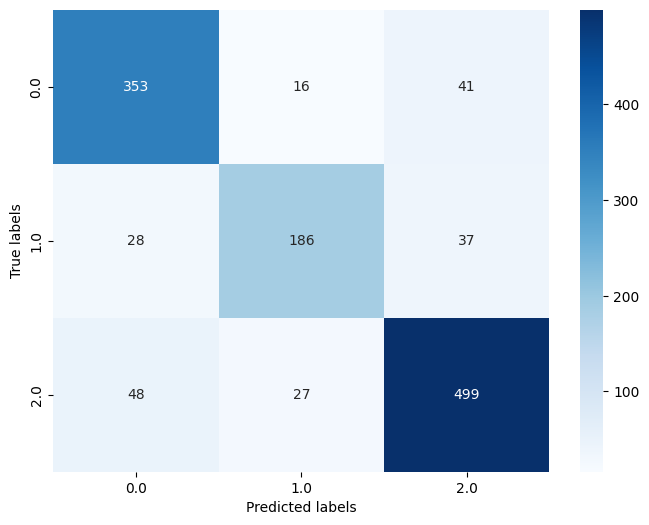

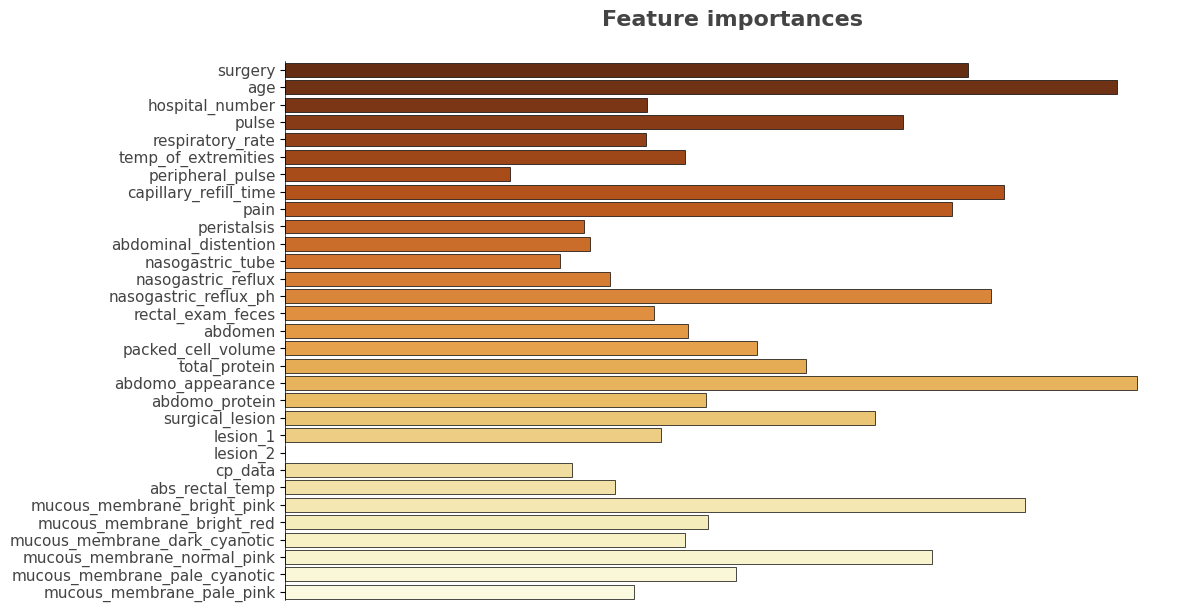

Visualization for lgb outcome
Micro-averaged F1-Score: 0.85668


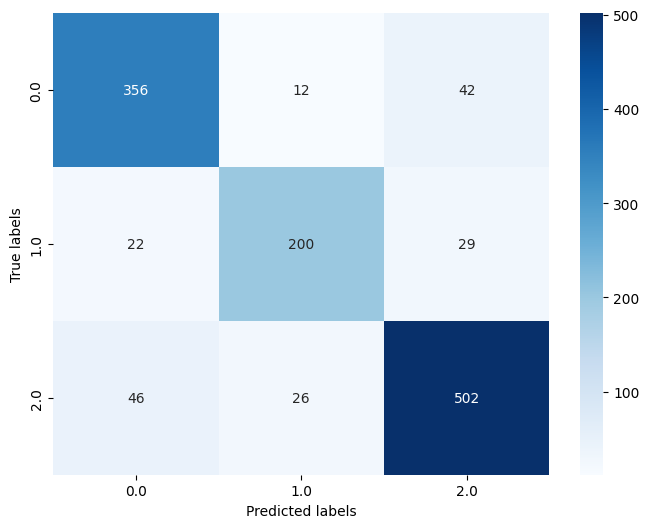

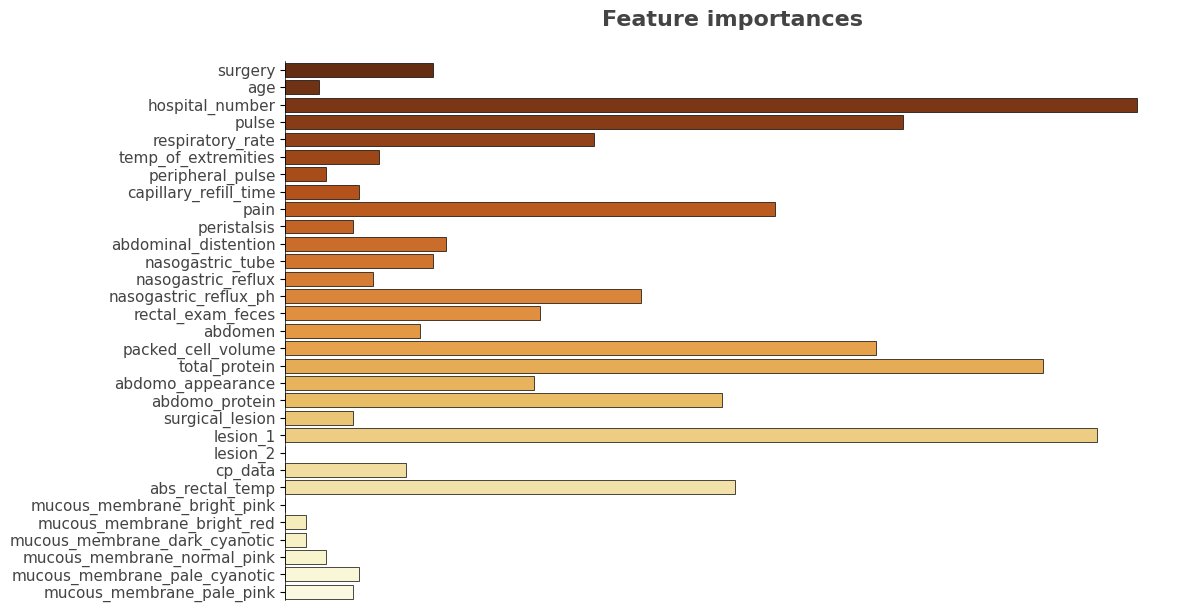

Visualization for cat outcome
Micro-averaged F1-Score: 0.95223


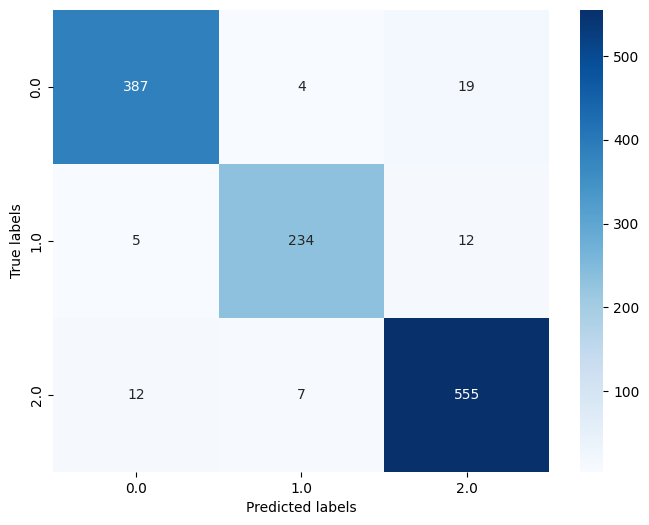

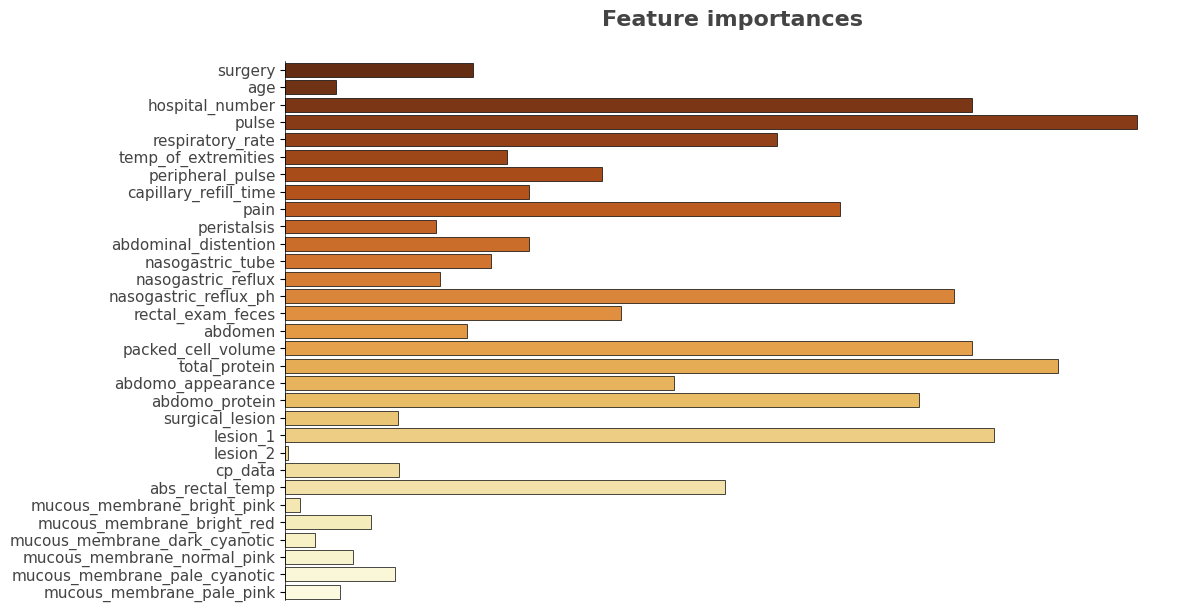

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix

def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title('Feature importances', size=16, y=1.05, 
              fontweight='bold', color='#444444')
    a = sns.barplot(data=f_imp, x='avg_imp', y='feature', 
                    palette='YlOrBr_r', linestyle="-", 
                    linewidth=0.5, edgecolor="black")
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11, color='#444444')
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()
    
def show_confusion(y_pred, y_true):
    # Assuming y_true and y_pred are numpy arrays
    labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

#code for evaulation and comparision + feature importance for each models.

for model_name, model_dict in best_models.items():
    for target in target_col:
        print(f'\033[1;34;4mVisualization for {model_name} {target}\033[0m')  # Blue with underline for model and target
        
        best_val_preds = model_dict[target].predict(train[features])
        f1 = f1_score(train[target], best_val_preds, average='micro')
        print(f'\033[1;35mMicro-averaged F1-Score: {f1:.5f}\033[0m')  # Purple for F1 scores

        # Confusion Matrix Visualization
        show_confusion(best_val_preds, train[target])

        # Feature Importance Visualization
        f_imp_df = pd.DataFrame({'feature': features, 'avg_imp': model_dict[target].feature_importances_})
        f_importance_plot(f_imp_df)

<div style="border-radius: 10px; border: #7c3aed solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📔 特徴の重要度 :</b> 入力特徴が目標変数を予測する際にどれだけ有用かに基づいてスコアを割り当てます。モデルの予測に最も影響を与える特徴が何かを理解するのに役立ちます。特に、特徴の選択、モデルの解釈性の向上、データの理解に役立ちます。
</div>


## 予測・提出

<div style="border-radius: 10px; border: #ffac00 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> ⚠️ オーバーフィッティング:</b> F1スコアは[0, 1]の範囲にあります。つまり、クロスバリデーションスコアとトレーニングスコアの差が0.06から0.15である場合、トレーニングセットにオーバーフィットしていること、つまり高分散問題であることを示します。これは、モデルが非常によく見たデータを予測できるが、未知のデータに汎化する際に問題があることを意味します。これを修正するために、モデルをアンサンブル化します。
</div>


In [12]:
models = [
    XGBClassifier(**xgb_params),
    LGBMClassifier(**lgb_params),
    CatBoostClassifier(**cat_params)
]

X_train = train.drop(columns='outcome')
y_train = train[['outcome']]
X_train = pd.DataFrame(data=X_train, columns=X_train.columns, index=train.index)

for model in models:
    model.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=5e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5e-07
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=0.5827352181078278 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=7.037147223984295 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] learning_rate is set=0.2, eta=0.020298153266306202 will be ignored. Current value: learning_rate=0.2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.4021844420871675 will be ignored. Current value: feature_fraction=0.7


In [13]:
X_test = pd.DataFrame(data=test, columns=test.columns, index=test.index)
X_test.head()

,id,surgery,age,hospital_number,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,pain,...,lesion_1,lesion_2,cp_data,abs_rectal_temp,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink
0,1235,0,0,0.002645,0.064935,0.136364,3,3,2,4,...,0.000000,0.0,0,37.207407,False,False,False,True,False,False
1,1236,1,0,0.001478,0.532468,0.454545,2,4,3,2,...,0.053710,0.0,1,37.281481,True,False,False,False,False,False
2,1237,1,0,0.001417,0.233766,0.045455,2,3,2,4,...,0.053637,0.0,1,37.374074,False,True,False,False,False,False
3,1238,0,0,0.002798,0.376623,0.136364,2,4,2,2,...,0.034055,0.0,0,37.485185,False,False,False,False,True,False
4,1239,1,0,0.001765,0.129870,0.045455,0,3,2,4,...,0.053710,0.0,1,37.262963,True,False,False,False,False,False


In [14]:
predictions = []
for model in models:
    predictions.append(model.predict(X_test).ravel())
    
predictions = np.array(predictions)

final_predictions, _ = stats.mode(predictions, axis=0)

final_predictions.shape

(824,)

<div style="border-radius: 10px; border: #7c3aed solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📔 OrdinalEncoder vs LabelEncoder :</b> この場合、ターゲットクラスに階層があるため、<code>OrdnialEncoder</code> の使用が適しています。単純に言えば、カテゴリカルデータに特定の順序がある場合（たとえば「低」「中」「高」など）、<code>OrdnialEncoder</code> を使用します。順序がない場合（たとえば「猫」「犬」「クジラ」など）、<code>LabelEncoder</code> を使用します。
</div>


### 提出 🏆
***
今、トレーニングセットで行ったのと同様の手順で、テストセットにすべての変換を適用できます。このコンペティションの場合、それほど多くはありません。


In [15]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e22/sample_submission.csv', index_col='id')

# 提出ファイルの作成
target = train['outcome']
y_map = {k: v for v, k in enumerate(target.unique())}
y_reverse_map = {v: k for k, v in y_map.items()}

submission['outcome'] = final_predictions[0]
submission.outcome = submission.outcome.map(y_reverse_map)


submission.to_csv(OUTPUT_DIR + 'submission.csv')

<div style="border-radius: 10px; border: #27374D solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📉 Submission :</b> 当社のモデルは、0から2までの整数でクラスを予測しますが、提出にはクラス名が必要です。そのため、<code>inverse_transform()</code> を使用して数値をクラス名に変換します。なお、<code>transform()</code> はクラス名（文字列）を整数にマップするので、<code>inverse_transform()</code> はその逆を行います。
</div>


In [16]:
submission

,outcome
id,
1235,2.0
1236,2.0
1237,2.0
1238,2.0
1239,2.0
...,...
2054,2.0
2055,2.0
2056,2.0
